In [1]:
import torch

In [2]:
# x = torch.randn(2, 3, requires_grad=True)
x = torch.rand(2, 3).requires_grad_()
print(x.requires_grad)

True


In [3]:
a = torch.randn(2, 3, requires_grad=True)
b = torch.zeros(2, 3)
c = (a + b).sum()
a.requires_grad, b.requires_grad, c.requires_grad

(True, False, True)

In [4]:
a.is_leaf, b.is_leaf, c.is_leaf

(True, True, False)

In [5]:
# autograd 求导
# y = x^2 * e^x
def f(x):
    y = x * x * torch.exp(x)
    return y


def df(x):
    df = 2 * x * torch.exp(x) + x * x * torch.exp(x)
    return df

In [6]:
x = torch.randn(2, 3, requires_grad=True)
y = f(x)
y

tensor([[2.7730e-01, 6.5675e-02, 1.5995e-01],
        [2.9430e-01, 8.2385e-04, 2.9834e+00]], grad_fn=<MulBackward0>)

In [7]:
y.backward(gradient=torch.ones(y.size()))  # 指定
# torch.autograd.backward(y, grad_tensors=torch.ones(y.size()))  # 或者

In [8]:
x.grad

tensor([[ 1.5803, -0.3761, -0.4573],
        [-0.4273, -0.0558,  8.7688]])

In [9]:
df(x)

tensor([[ 1.5803, -0.3761, -0.4573],
        [-0.4273, -0.0558,  8.7688]], grad_fn=<AddBackward0>)

In [10]:
# 计算图
x = torch.ones(1)
b = torch.rand(1, requires_grad=True)
w = torch.rand(1, requires_grad=True)
y = w * x  # 等价于 y = w.mul(x)
z = y + b  # 等价于 z = y.add(b)

x.requires_grad, b.requires_grad, w.requires_grad, y.requires_grad, z.requires_grad

(False, True, True, True, True)

In [11]:
z.grad_fn

In [12]:
y.grad_fn

In [13]:
w.grad_fn, x.grad_fn, b.grad_fn

(None, None, None)

In [14]:
z.grad_fn.next_functions

((<MulBackward0 at 0x23d79c2b460>, 0), (<AccumulateGrad at 0x23d781923e0>, 0))

In [15]:
y.grad_fn.next_functions

((<AccumulateGrad at 0x23d77be1060>, 0), (None, 0))

In [16]:
z.backward(retain_graph=True)

In [17]:
w.grad

tensor([1.])

In [18]:
z.backward()
w.grad

tensor([2.])

In [19]:
# 关闭反向传播
x = torch.ones(1)
w = torch.rand(1, requires_grad=True)
y = x * w

x.requires_grad, w.requires_grad, y.requires_grad  # y.requires_grad = True
# (False, True, True)

(False, True, True)

In [20]:
with torch.no_grad():
    x = torch.ones(1)
    w = torch.rand(1, requires_grad=True)
    y = x * w

x.requires_grad, w.requires_grad, y.requires_grad  # y.requires_grad = False
# (False, True, False)

(False, True, False)

In [21]:
torch.set_grad_enabled(False)  # 更改默认设置
x = torch.ones(1)
w = torch.rand(1, requires_grad=True)
y = x * w

x.requires_grad, w.requires_grad, y.requires_grad  # y.requires_grad = False
# (False, True, False)
# torch.set_grad_enabled(True) # 更改回默认设置

(False, True, False)

In [22]:
torch.set_grad_enabled(True)  # 更改回默认设置

In [23]:
x = torch.ones(1, requires_grad=True)
x_clone = x.data
x.requires_grad, x_clone.requires_grad

(True, False)

In [24]:
# autograd.grad & hook
x = torch.ones(1, requires_grad=True)
w = torch.ones(1, requires_grad=True)
y = w * x  # 非叶子结点
z = y.sum()  # 非叶子结点

In [25]:
# z.backward()
z.backward(retain_graph=True)
x.grad, w.grad, y.grad

C:\Users\15056\AppData\Local\Temp\ipykernel_5060\679935330.py:3: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\build\aten\src\ATen/core/TensorBody.h:494.)
  x.grad, w.grad, y.grad


(tensor([1.]), tensor([1.]), None)

In [26]:
# 使用 torch.autograd.grad() 直接取梯度
x = torch.ones(1, requires_grad=True)
w = torch.ones(1, requires_grad=True)
y = x * w
z = y.sum()

torch.autograd.grad(z, y)  # z.backward() 并直接取 y.grad()

(tensor([1.]),)

In [27]:
# hook是一个函数，输入是梯度，不应该有返回值
def variable_hook(grad):
    print('y.grad：', grad)


x = torch.ones(1, requires_grad=True)
w = torch.ones(1, requires_grad=True)

y = x * w
# 注册hook
hook_handle = y.register_hook(variable_hook)

z = y.sum()
z.backward()

# 除非每次都要使用 hook，否则用完之后记得移除 hook
hook_handle.remove()

y.grad： tensor([1.])


线性回归

In [28]:
import torch
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

def get_fake_data(batch_size=16):
    # 产生随机数据：y = 2 * x + 3，加上噪声
    x = torch.rand(batch_size, 1) * 5  # 扩大一些，以免噪声太明显
    y = x * 2 + 3 + torch.randn(batch_size, 1)
    return x, y

# 设置随机数种子，保证结果可复现
torch.manual_seed(1000)

x, y = get_fake_data()

# plt.scatter(x.squeeze().numpy(), y.squeeze().numpy())
# plt.show()

# 初始化
w = torch.rand(1, 1, requires_grad=True)  # w.shape = torch.Size([1, 1]) 因为 [8, 1] * [1, 1] -> [batch_size, 1] 和 y 维度相同
b = torch.zeros(1, 1, requires_grad=True)

losses = np.zeros(200)  # 存储损失值
lr = 0.005  # 学习率
EPOCHS = 200  # 迭代次数

for epoch in range(EPOCHS):
    x, y = get_fake_data(batch_size=32)

    # 前向传播 计算损失
    y_pred = x.mm(w) + b.expand_as(y)  # expand_as(y) 是广播机制，即将 b 复制成和 y 相同性质的张量 [1, 1] -> [batch_size, 1]
    loss = 0.5 * (y_pred - y) ** 2  # MSE 均方误差，这是对张量 y 逐元素计算
    loss = loss.sum()  # 累和成一个数
    losses[epoch] = loss.item()

    # 反向传播
    loss.backward()

    ''' 取 .data 是因为每一轮是根据随机生成的 batch_size 个点训练，但我们希望存储的是全局参数 w, b '''
    ''' 故每次依据样本点更新全局参数，而不是改批次的参数 '''
    # 更新参数
    w.data.sub_(lr * w.grad.data)  # 或者 w.data = w.data - lr * w.grad.data
    b.data.sub_(lr * b.grad.data)

    # 梯度清零
    w.grad.data.zero_()  # 不清零，梯度会不断累加
    b.grad.data.zero_()

    if epoch % 10 == 0:  # 每隔 10 次扔出当前训练情况
        print("Epoch: {} / {}, Parameters: w is {}, b is {}, Loss: {}".format(epoch, EPOCHS, w.item(), b.item(), losses[epoch]))

print("Epoch: {} / {}, Parameters: w is {}, b is {}, Loss: {}".format(EPOCHS, EPOCHS, w.item(), b.item(), losses[-1]))

Epoch: 0 / 200, Parameters: w is 4.3238725662231445, b is 1.0881009101867676, Loss: 829.963623046875
Epoch: 10 / 200, Parameters: w is 2.4952096939086914, b is 1.434689998626709, Loss: 22.862998962402344
Epoch: 20 / 200, Parameters: w is 2.461652994155884, b is 1.9093929529190063, Loss: 26.772274017333984
Epoch: 30 / 200, Parameters: w is 2.249239206314087, b is 2.2639613151550293, Loss: 23.66741180419922
Epoch: 40 / 200, Parameters: w is 2.204271078109741, b is 2.511821985244751, Loss: 30.240798950195312
Epoch: 50 / 200, Parameters: w is 2.119697332382202, b is 2.6827428340911865, Loss: 23.725893020629883
Epoch: 60 / 200, Parameters: w is 2.012115716934204, b is 2.7549595832824707, Loss: 18.38174819946289
Epoch: 70 / 200, Parameters: w is 2.1640625, b is 2.945894479751587, Loss: 16.762752532958984
Epoch: 80 / 200, Parameters: w is 2.1478612422943115, b is 2.889162063598633, Loss: 14.00448226928711
Epoch: 90 / 200, Parameters: w is 1.9468457698822021, b is 2.880192995071411, Loss: 9.30

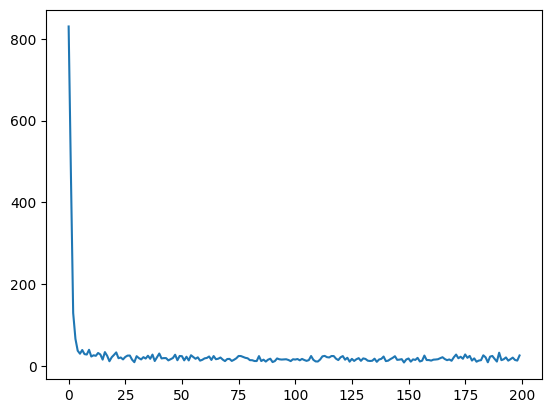

In [29]:
plt.plot(losses)
plt.show()

GPU 加速

In [30]:
import torch
import numpy as np
from matplotlib import pyplot as plt

# 检查是否有可用的 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def get_fake_data(batch_size=16):
    # 产生随机数据：y = 2 * x + 3，加上噪声
    x = torch.rand(batch_size, 1, device=device) * 5  # 将数据移动到 GPU
    y = x * 2 + 3 + torch.randn(batch_size, 1, device=device)  # 将数据移动到 GPU
    return x, y

# 设置随机数种子，保证结果可复现
torch.manual_seed(1000)
if torch.cuda.is_available():
    torch.cuda.manual_seed(1000)  # 为 CUDA 设置随机种子

# 初始化参数，并将参数移动到 GPU
w = torch.rand(1, 1, requires_grad=True, device=device)  # 将 w 移动到 GPU
b = torch.zeros(1, 1, requires_grad=True, device=device)  # 将 b 移动到 GPU

losses = np.zeros(200)  # 存储损失值
lr = 0.005  # 学习率
EPOCHS = 200  # 迭代次数

for epoch in range(EPOCHS):
    x, y = get_fake_data(batch_size=32)

    # 前向传播 计算损失
    y_pred = x.mm(w) + b.expand_as(y)  # expand_as(y) 是广播机制，即将 b 复制成和 y 相同性质的张量 [1, 1] -> [batch_size, 1]
    loss = 0.5 * (y_pred - y) ** 2  # MSE 均方误差，这是对张量 y 逐元素计算
    loss = loss.sum()  # 累和成一个数
    losses[epoch] = loss.item()

    # 反向传播
    loss.backward()

    # 更新参数
    w.data.sub_(lr * w.grad.data)  # 或者 w.data = w.data - lr * w.grad.data
    b.data.sub_(lr * b.grad.data)

    # 梯度清零
    w.grad.data.zero_()  # 不清零，梯度会不断累加
    b.grad.data.zero_()

    if epoch % 10 == 0:  # 每隔 10 次打印当前训练情况
        print("Epoch: {} / {}, Parameters: w is {}, b is {}, Loss: {}".format(epoch, EPOCHS, w.item(), b.item(), losses[epoch]))

print("Epoch: {} / {}, Parameters: w is {}, b is {}, Loss: {}".format(EPOCHS, EPOCHS, w.item(), b.item(), losses[-1]))

Using device: cuda
Epoch: 0 / 200, Parameters: w is 3.928750514984131, b is 1.139615774154663, Loss: 912.879150390625
Epoch: 10 / 200, Parameters: w is 2.3561320304870605, b is 1.4272336959838867, Loss: 36.63234329223633
Epoch: 20 / 200, Parameters: w is 2.383948802947998, b is 1.9468510150909424, Loss: 17.98131561279297
Epoch: 30 / 200, Parameters: w is 2.189819574356079, b is 2.2746236324310303, Loss: 20.94324493408203
Epoch: 40 / 200, Parameters: w is 1.945842981338501, b is 2.3835673332214355, Loss: 32.365966796875
Epoch: 50 / 200, Parameters: w is 2.2329907417297363, b is 2.6647489070892334, Loss: 21.734416961669922
Epoch: 60 / 200, Parameters: w is 2.099648952484131, b is 2.772085428237915, Loss: 11.034501075744629
Epoch: 70 / 200, Parameters: w is 2.1312642097473145, b is 2.880796432495117, Loss: 22.206199645996094
Epoch: 80 / 200, Parameters: w is 2.080796957015991, b is 2.8835976123809814, Loss: 12.214717864990234
Epoch: 90 / 200, Parameters: w is 1.9547618627548218, b is 2.84

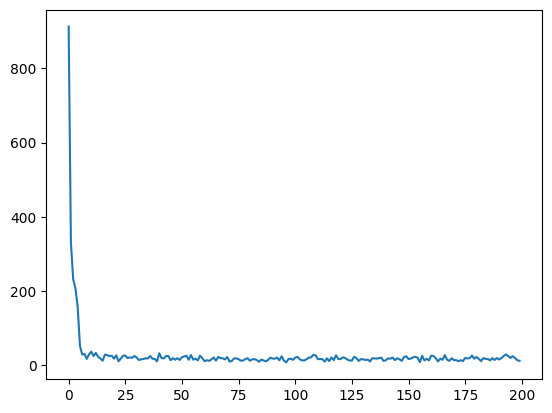

In [31]:
plt.plot(losses)
plt.show()